# 0.0 Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import inflection 
import plotly.express as px
import umap.umap_ as umap

from matplotlib import pyplot as plt
from IPython.display import HTML
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn import metrics


/home/natan/miniconda3/envs/clusterenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 0.1 Helper Functions

### Set Display

In [4]:
def notebook_settings():

    plt.style.use( 'ggplot' )
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24

    display(HTML('<style>.container {width:100% !important;}</style>'))
    pd.options.display.max_columns=None
    pd.options.display.max_rows=None
    pd.set_option( 'display.expand_frame_repr', False)

    sns.set()
notebook_settings()

In [5]:
# supress scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## 0.2 Load Data

In [6]:
data = pd.read_csv('../data/raw/data.csv', encoding='unicode_escape')

# Planification (IoT)

# 1.0 Data Description

### 1.1 Data Dimensions

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [6]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.550,17850.000,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.390,17850.000,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.750,17850.000,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.390,17850.000,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.390,17850.000,United Kingdom


### 1.2 Rename Columns

In [7]:
cols_old = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country']

snakecase = lambda x: inflection.underscore( x ) # change to snakecase
cols_new = list( map( snakecase, cols_old ))

data.columns = cols_new # define the new columns

### 1.3 Check and fillout Nan

In [8]:
# check Na
data.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

In [8]:
# drop Na
df1 = data.dropna(subset=['description', 'customer_id'])

### 1.4 Change dtypes

In [9]:
# invoice data to datetime
df1['invoice_date'] = pd.to_datetime(df1['invoice_date']).dt.date
#df1['invoice_date'] = df1['invoice_date'].dt.date

# customer id
df1['customer_id'] = df1['customer_id'].astype(int)

/tmp/ipykernel_87767/1837987786.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['invoice_date'] = pd.to_datetime(df1['invoice_date']).dt.date
/tmp/ipykernel_87767/1837987786.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['customer_id'] = df1['customer_id'].astype(int)


### 1.5 Descriptive Statistics

In [53]:
num_att = data.select_dtypes(include=['int64', 'float64'])
cat_att = data.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])

#### Numerical

In [67]:
# central tendency - mean and median
mean = pd.DataFrame(num_att.apply( np.mean )).T
median = pd.DataFrame(num_att.apply( np.median )).T

# dispertion - std, min, max, range, skew, kurtosis
std = pd.DataFrame(num_att.apply( np.std )).T
min_ = pd.DataFrame(num_att.apply( np.min )).T
max_ = pd.DataFrame(num_att.apply( np. max )).T
range_ = pd.DataFrame(num_att.apply( lambda x: x.max() - x.min())).T
skew = pd.DataFrame(num_att.apply( lambda x: x.skew())).T
kurtosis = pd.DataFrame(num_att.apply( lambda x: x.kurtosis())).T

# concatenate
description = pd.concat([mean, median, std, min_, max_, range_, skew, kurtosis]).T.reset_index()
description.columns = ['index', 'mean', 'median', 'std', 'min', 'max', 'range', 'skew', 'kurtosis']


In [68]:
description

,index,mean,median,std,min,max,range,skew,kurtosis
0,quantity,12.061,5.000,248.693,-80995.000,80995.000,161990.000,0.183,94317.564
1,unit_price,3.460,1.950,69.315,0.000,38970.000,38970.000,452.219,246924.543
2,customer_id,15287.691,15152.000,1713.598,12346.000,18287.000,5941.000,0.030,-1.180


#### Categorical

In [ ]:
data.columns

Index(['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country'],
      dtype='object')

# 2.0 Feature Engineering

In [10]:
df2 = df1.copy()

In [11]:
# date reference 
df_ref = df2.drop(['invoice_no', 'stock_code', 'description', 
                   'quantity', 'invoice_date', 'unit_price', 
                   'country'], axis=1).drop_duplicates(ignore_index=True)

In [12]:
# Gross revenue (quantity * price)
df2['revenue'] = df2['unit_price'] * df2['quantity']

# Monetery
monetary = df2[['customer_id', 'revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, monetary, on='customer_id', how='left')

# Recency (the last purchase)
recency = df2[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
recency['recency_days'] = (df2['invoice_date'].max() - recency['invoice_date']).apply(lambda x: x.days)
recency = recency[['customer_id', 'recency_days']]
df_ref = pd.merge(df_ref, recency, on='customer_id', how='left')

# Frequency 
frequency = df2[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
frequency.columns = ['customer_id', 'frequency']
df_ref = pd.merge(df_ref, frequency, on='customer_id', how='left')

# 3.0 Data Filtering

# 4.0 EDA

## 4.1 Hypothesis Map

## 4.2 Univariate Analysis

# 5.0 Data Preparation

### Standardization, Rescaling and Encoding

# 6.0 Feature Selection

## 6.1 Split Train & Validation

## 6.2 Fature Selection

### Boruta

### Fature Importance

# 7.0 Hyperparameter Fine-Tunning

In [13]:
df2 = df_ref.copy()
X = df2.drop( columns=['customer_id'] )

In [14]:
cluster = [2, 3, 4, 5, 6, 7, 8, 9, 10]

### Within-Cluster Sum of Squares (WSS)

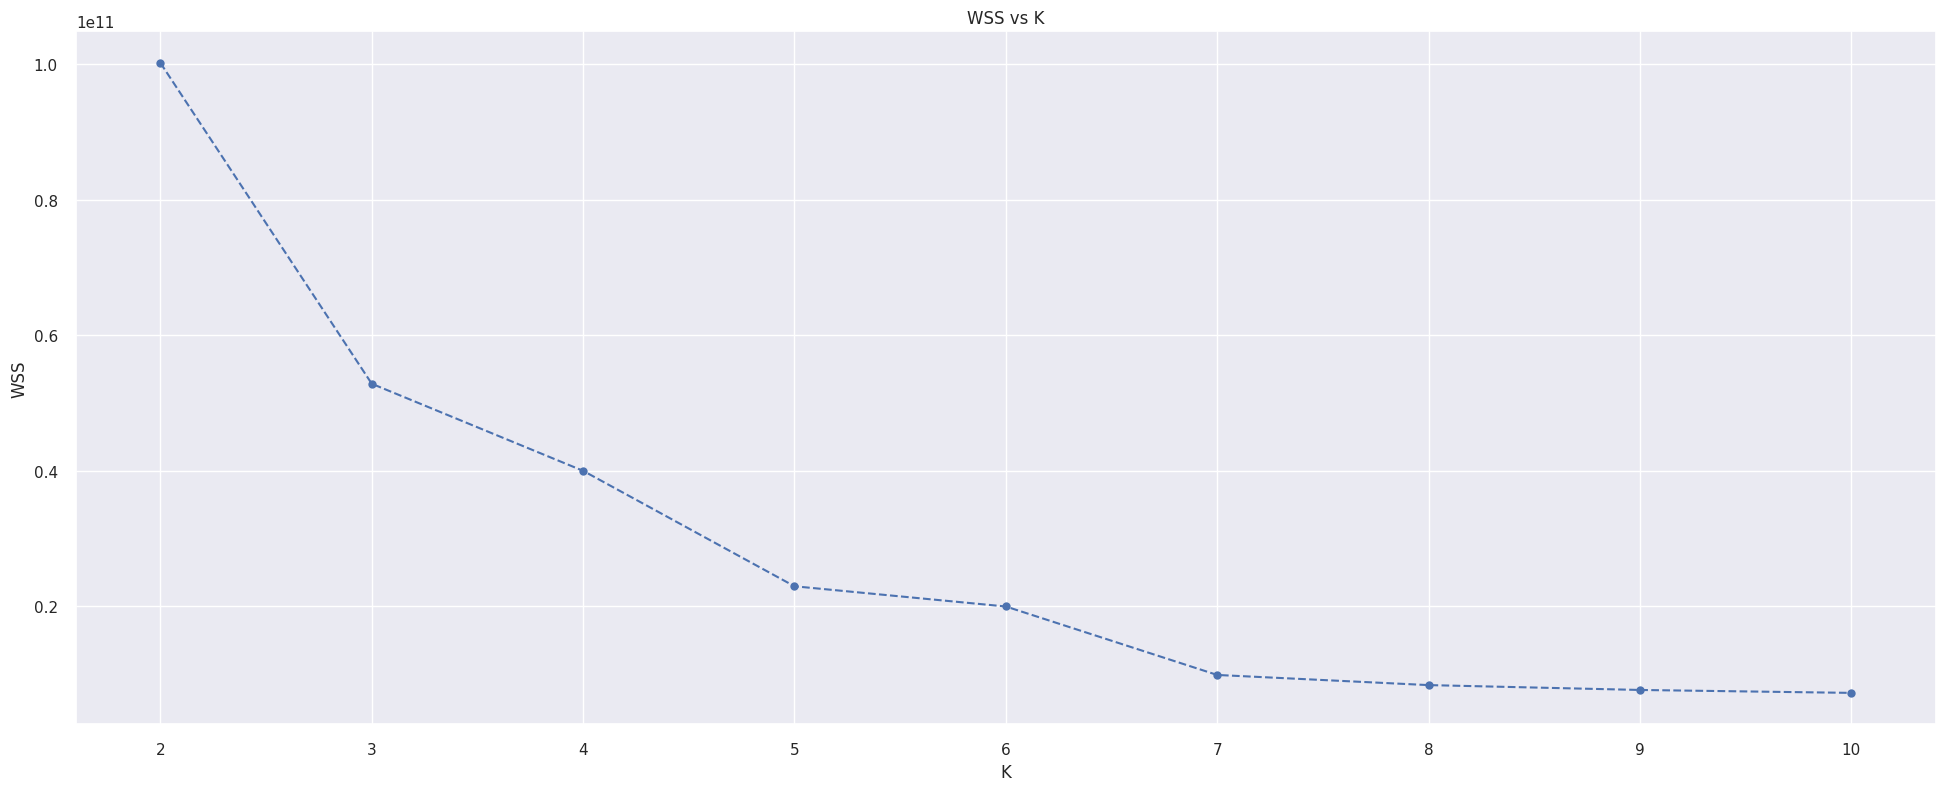

In [15]:
wss = []
for k in cluster:
    # model definition
    kmeans = KMeans(init='random', n_clusters=k, n_init=10,  max_iter=300, random_state=42)

    # model training
    kmeans.fit( X )

    #validation
    wss.append(kmeans.inertia_)

# plot wss - Elbow Method
plt.plot(cluster, wss, linestyle='--', marker='o');
plt.xlabel( 'K' );
plt.ylabel( 'WSS' );
plt.title('WSS vs K');

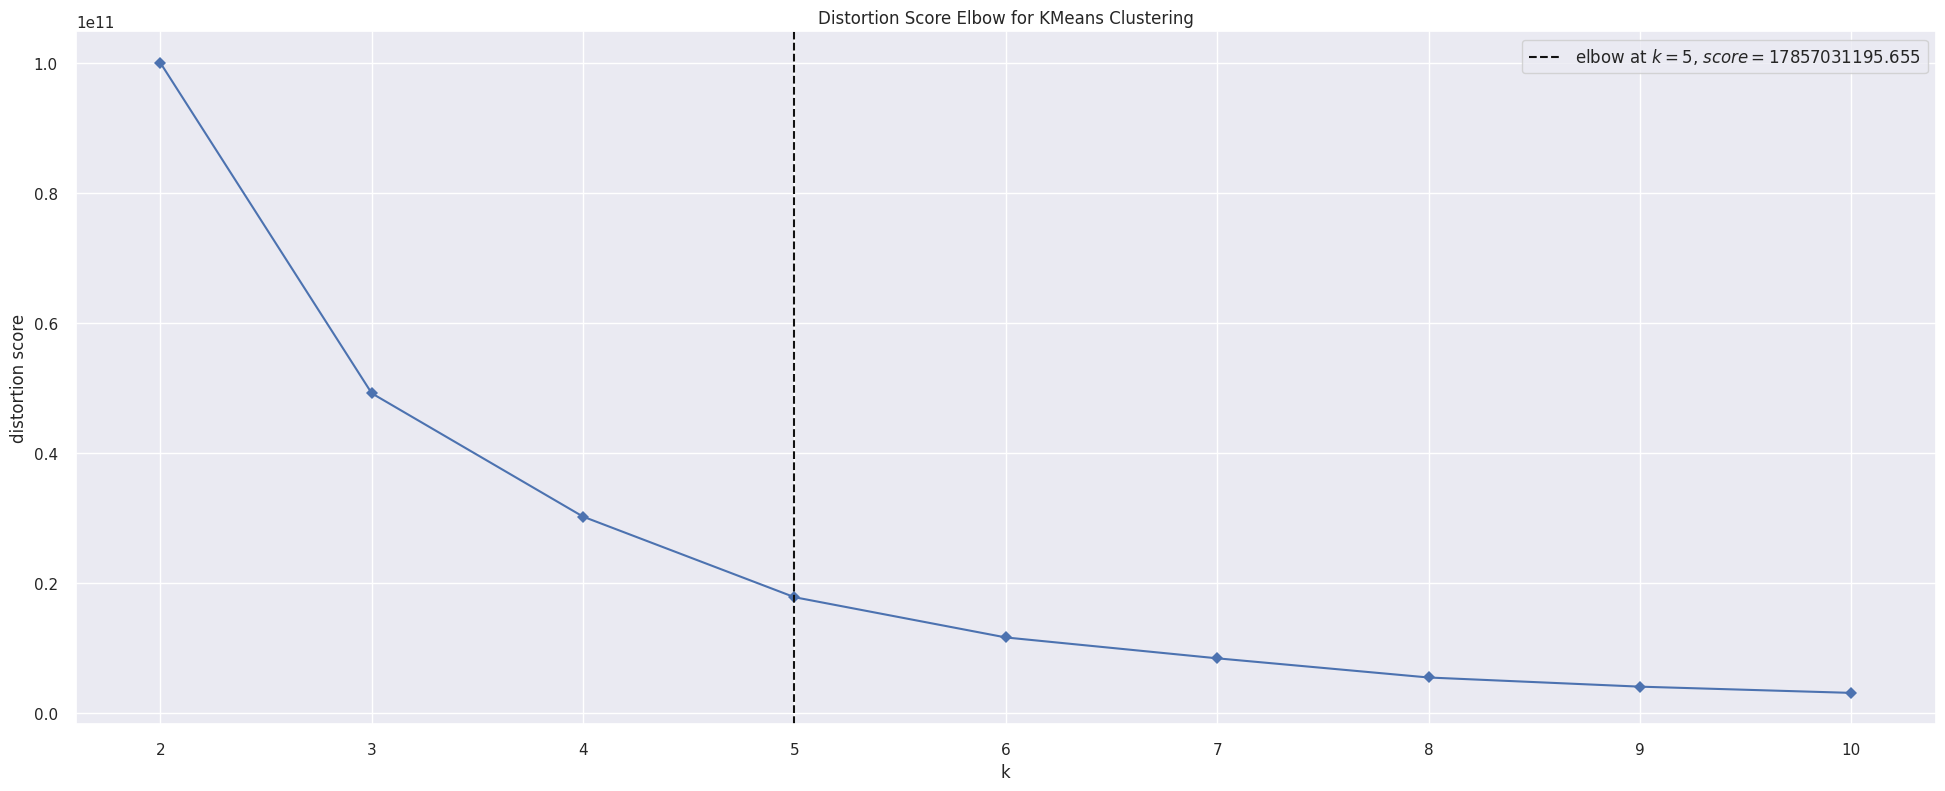

In [17]:
# yellowbrick library
kmeans = KElbowVisualizer( KMeans(n_init=10), k=cluster, timings=False)
kmeans.fit( X );
kmeans.show();

### Silhouette Score

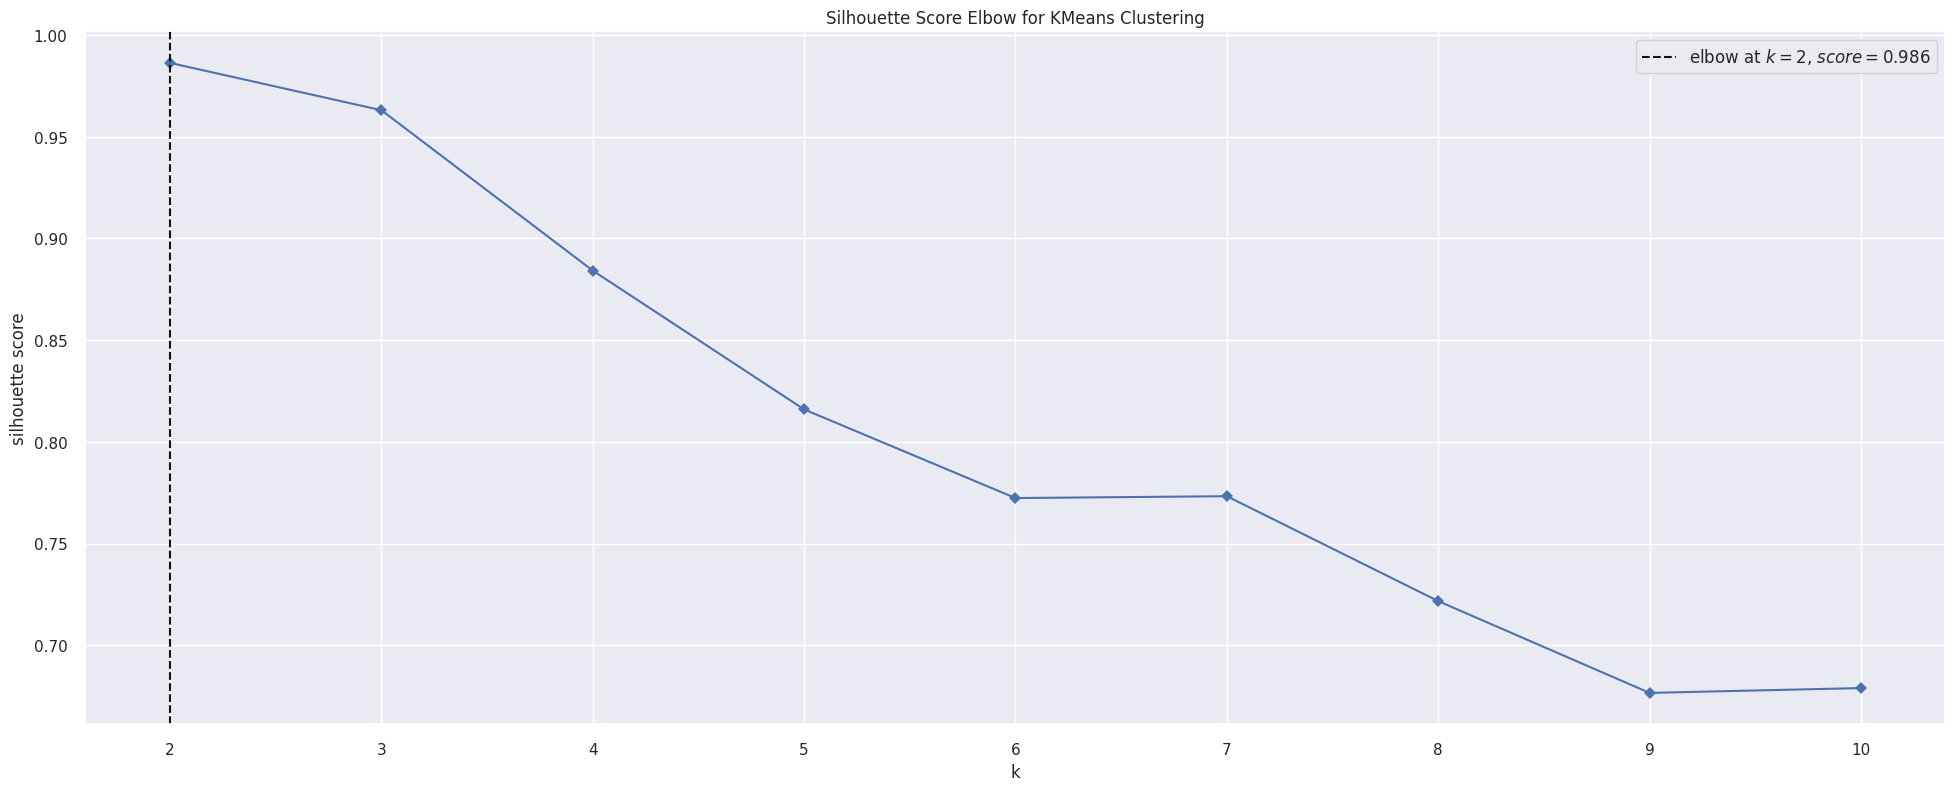

In [18]:
kmenas = KElbowVisualizer( KMeans(n_init=10), k=cluster, metric='silhouette', timings=False);
kmenas.fit( X );
kmenas.show();

### Silhouette Analysis

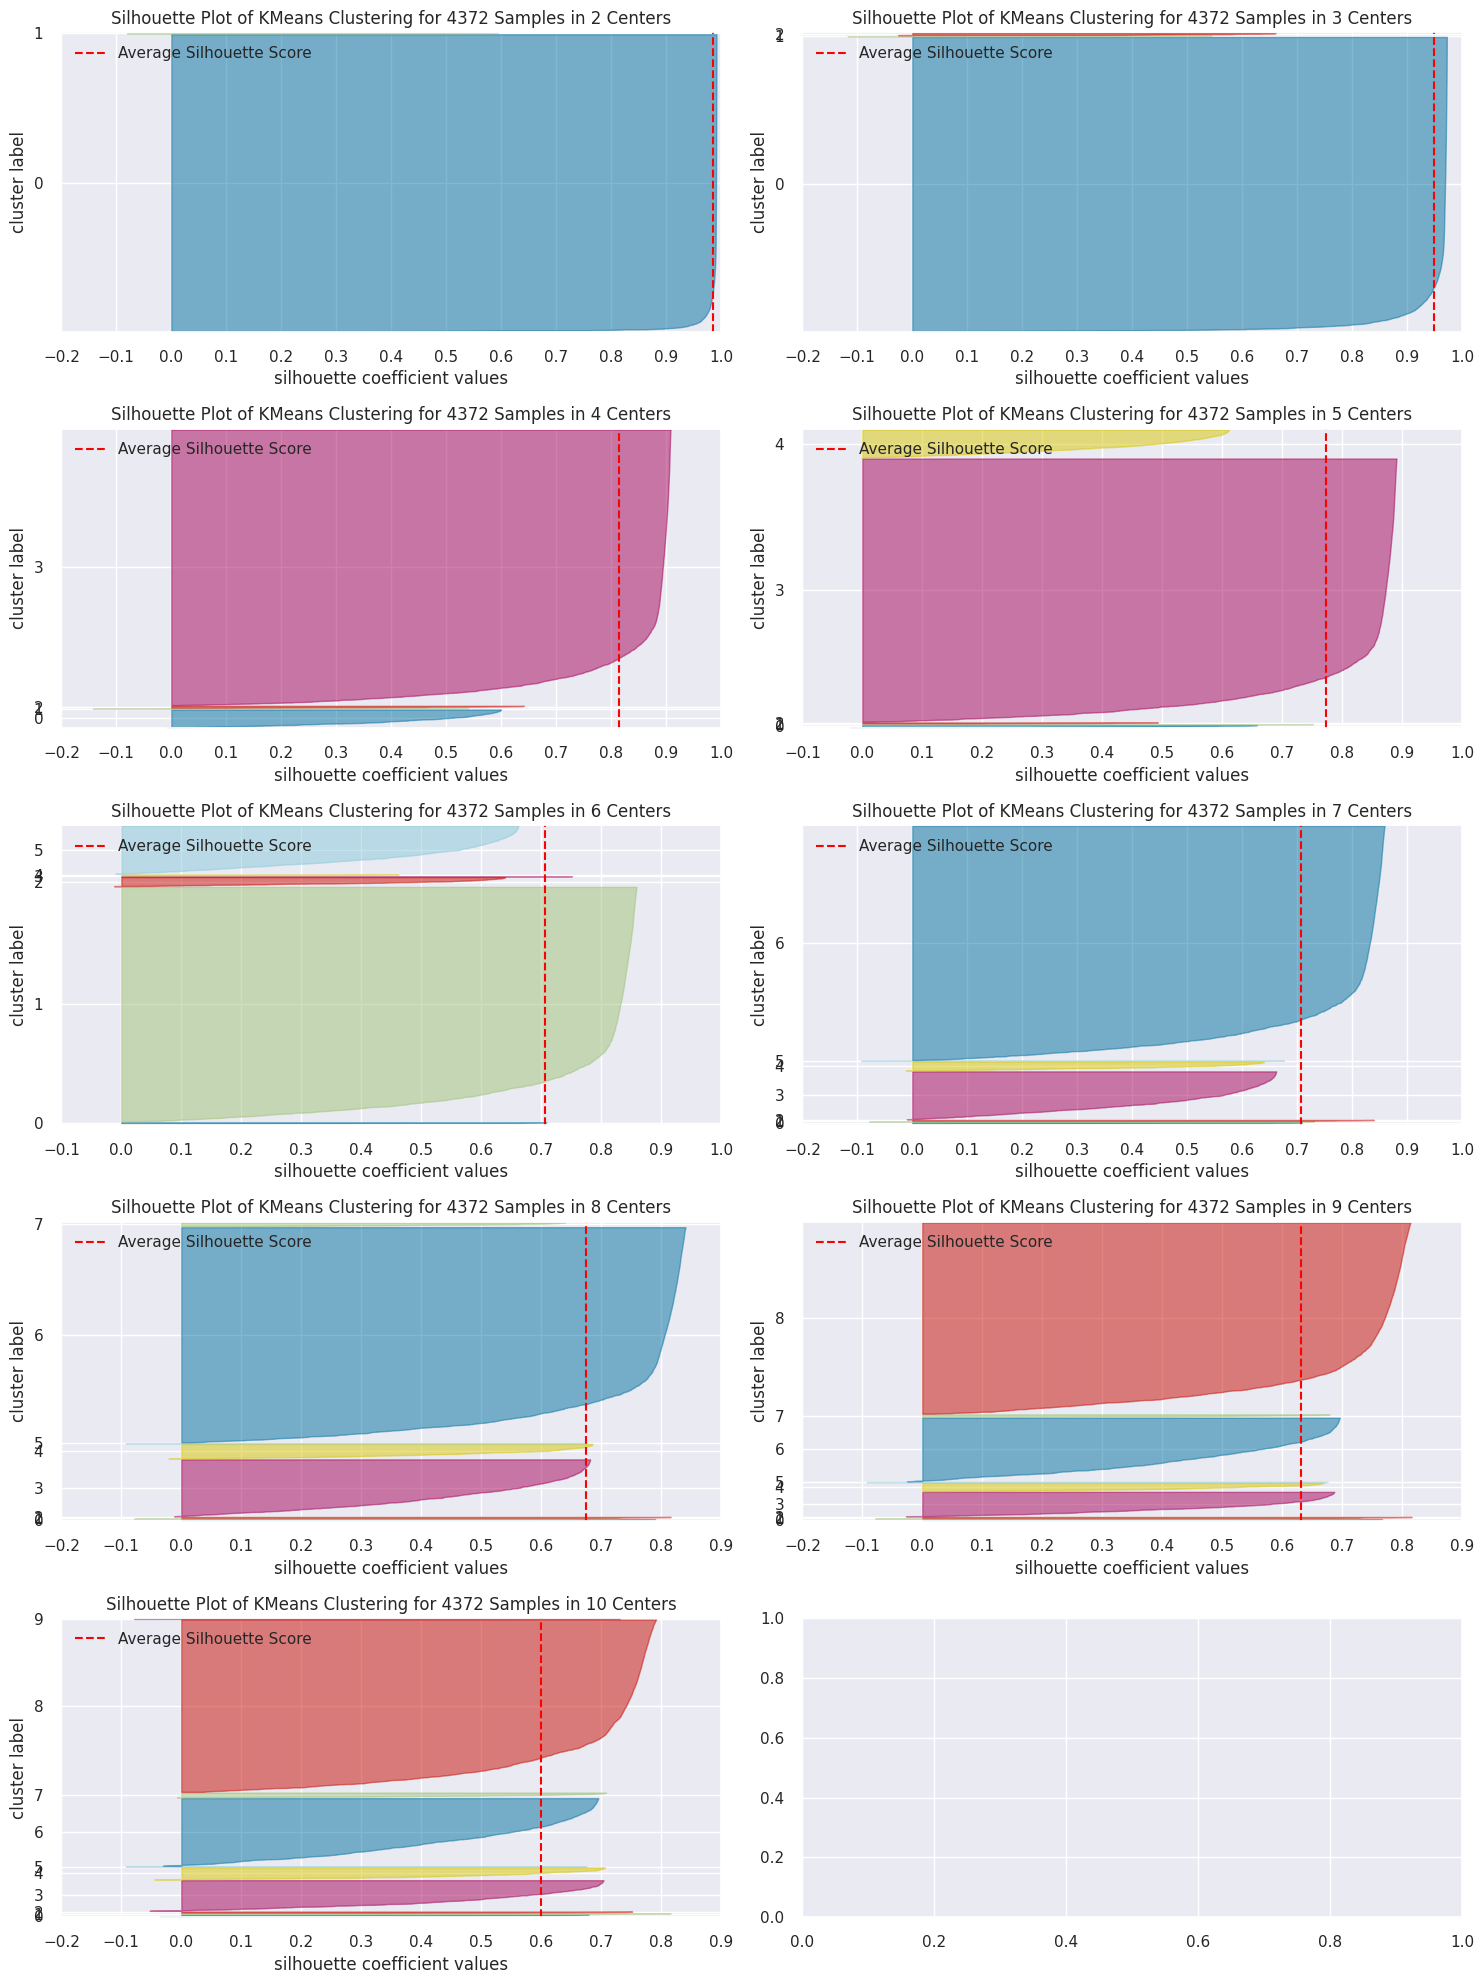

In [19]:
fig, ax = plt.subplots(5, 2, figsize=(15,20))

for k in cluster:
    km = KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod( k - 2, 2)

    viz = SilhouetteVisualizer( km, colors='yellowbrick', ax=ax[q][mod])
    viz.fit( X )
    viz.finalize()

plt.tight_layout()
plt.show()

# 8.0 Machine Learnign Modeling

In [26]:
# model definition
k = 3
kmeans = KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

# model trainig 
kmeans.fit ( X )

# clustering
labels = kmeans.labels_

### Cluster Validation

In [27]:
# WSS 
print( f'WSS value: {kmeans.inertia_}')

# Silhouette
print(f'SS Value: {metrics.silhouette_score( X, labels, metric="euclidean")}')

WSS value: 52830442008.00695
SS Value: 0.9494677566681542


# 9.0 Cluster Analysis

In [29]:
df3 = df_ref.copy()
df3['cluster'] = labels

### Visualization Inspection

In [31]:
# 3 clusters and without avg ticket
fig = px.scatter_3d(df3, x='recency_days', y='frequency', z='revenue', color='cluster')
fig.show()

/home/natan/miniconda3/envs/clusterenv/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names



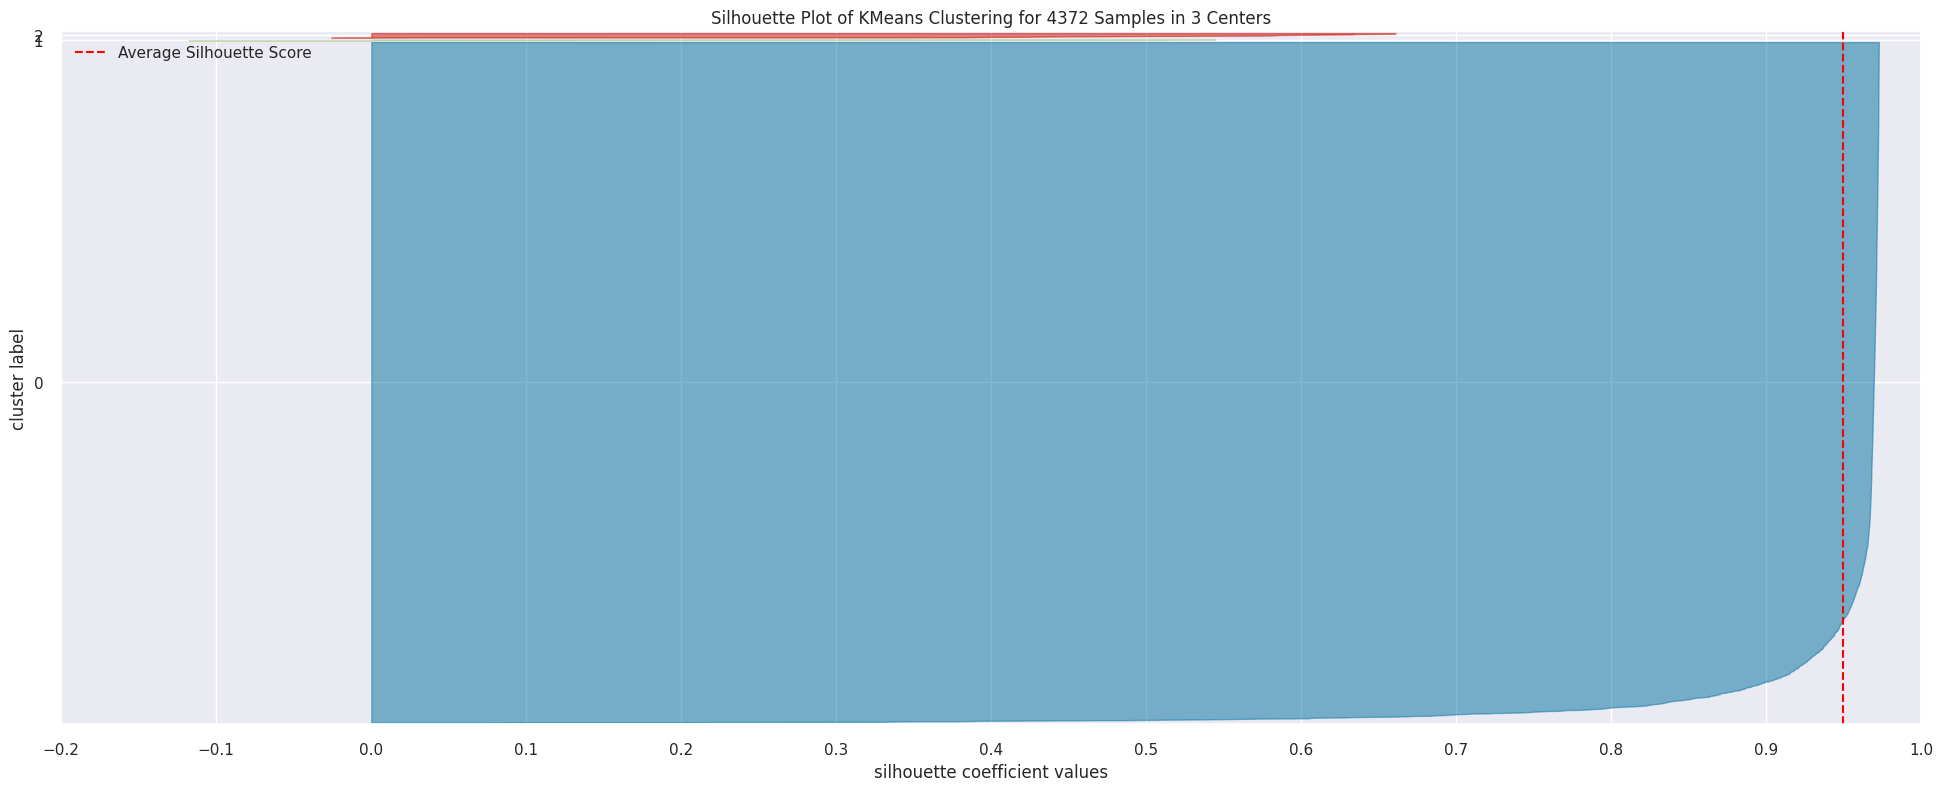

In [32]:
# 4 Clusters with avg ticket
viz = SilhouetteVisualizer( kmeans, colors='yellowbrick')
viz.fit( X )
viz.finalize()

### UMAP - t-SNE (Manifold)

/home/natan/miniconda3/envs/clusterenv/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.

/home/natan/miniconda3/envs/clusterenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/natan/miniconda3/envs/clusterenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/natan/miniconda3/envs/clusterenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/natan/miniconda3/envs/clusterenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarnin

<Axes: xlabel='embedding_x', ylabel='embedding_y'>

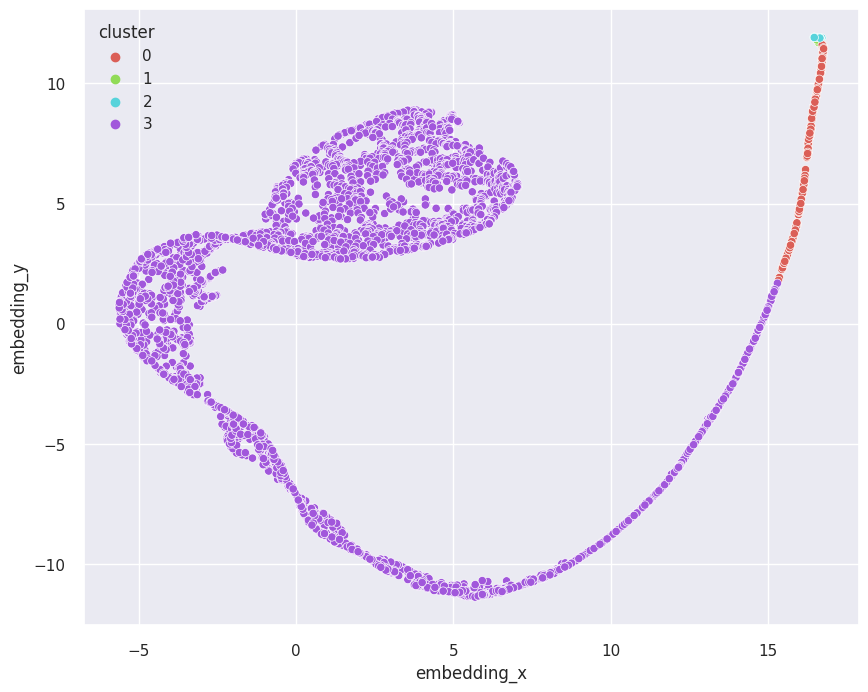

In [ ]:
reducer = umap.UMAP( n_neighbors=80, random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plot UMAP
plt.figure(figsize=(10,8))
sns.scatterplot(x='embedding_x', y='embedding_y', 
                data=df_viz, 
                hue='cluster', 
                palette=sns.color_palette( 'hls', n_colors=len(df_viz['cluster'].unique())))

### Cluster Profile

In [54]:
# Number of customers
df_cluster = df3[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['per_customer'] = 100 * df_cluster['customer_id'] / df_cluster['customer_id'].sum()

# Avg revenue
df_avg_revenue = df3[['revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_revenue, on='cluster', how='inner')

# Avg recency
df_avg_recency = df3[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency, on='cluster', how='inner')

# Avg frequency
df_avg_frequency = df3[['frequency', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_frequency, on='cluster', how='inner')

# Avg Ticket
# df_avg_ticket = df3[['avg_ticket', 'cluster']].groupby('cluster').mean().reset_index()
# df_cluster = pd.merge(df_cluster, df_avg_ticket, on='cluster', how='inner')

In [55]:
df_cluster

,cluster,customer_id,per_customer,revenue,recency_days,frequency
0,0,4335,99.154,1372.578,92.258,4.615
1,1,6,0.137,182181.982,7.167,89.000
2,2,31,0.709,40543.518,13.290,53.290


# 10.0 Deploy